### Image Search Exploration

This notebook demonstrates how to configure a MongoDB collection to store vector embeddings.
It then shows how to load images from disk and to use the [clip-ViT-L-14](https://huggingface.co/sentence-transformers/clip-ViT-L-14) multi-modal transformer to create embeddings for each image.

Finally, it demonstrates how to generate a vector embedding from a text phrase, using the same transformer, and to use that to look up appropriate images in the MongoDB collection.

In order to run this notebook, you'll need to set the `MONGODB_URI` environment variable to a connection string for a MongoDB cluster running MongoDB 7.0.2 or above.

In [1]:
# Uncomment the next line to install all the requirements:
#!pip install -r requirements.txt

In [25]:
%pip install opencv-python

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 51.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.7 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 105.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.2/809.2 kB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [15]:
%pip install --upgrade nltk

Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install numpy==1.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 70.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ done
  Preparing metadata (pyproject.toml) ... - \ done
  Created wheel for numpy: filename=numpy-1.21.0-cp310-cp310-linux_x86_64.whl size=5301810 sha256=d987c55f6e08c945d8ab3c04be64a4e7f680711e1e237ec742cd933eb86953fd
  Stored in directory: /home/azureuser/.cache/pip/wheels/05/61/d1/ccc2cd557b39e127ad98a392d9558f3c5dda28764b7f54b2f5
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.8.1.78 requires numpy>=1.21.2; python_version >= "3.10", but you have numpy 1.21.0 whic

In [1]:
%pip list

Package                       Version
----------------------------- ------------
adal                          1.2.7
aiosignal                     1.3.1
alembic                       1.11.1
argcomplete                   2.1.2
asttokens                     2.4.1
attrs                         23.1.0
azure-ai-ml                   1.8.0
azure-common                  1.1.28
azure-core                    1.27.1
azure-graphrbac               0.61.1
azure-identity                1.13.0
azure-mgmt-authorization      3.0.0
azure-mgmt-containerregistry  10.1.0
azure-mgmt-core               1.4.0
azure-mgmt-keyvault           10.2.2
azure-mgmt-resource           22.0.0
azure-mgmt-storage            21.0.0
azure-storage-blob            12.16.0
azure-storage-file-datalake   12.11.0
azure-storage-file-share      12.12.0
azureml-core                  1.51.0.post1
azureml-dataprep              4.11.3
azureml-dataprep-native       38.0.0
azureml-dataprep-rslex        2.18.3
azureml-fsspec               

In [2]:
from glob import glob
from math import ceil
import os
from pathlib import Path
from random import choices
import re

import cv2
import matplotlib.pyplot as plt
from PIL import Image

# I'm using MongoDB as my vector database:
from pymongo import MongoClient
from pymongo.errors import CollectionInvalid, DuplicateKeyError
from pymongo.operations import SearchIndexModel

from sentence_transformers import SentenceTransformer # The transformer used to execute the clip model.
from tqdm.notebook import tqdm                        # Nice progress bars
from dotenv import load_dotenv
import os

In [8]:
# Load the environment variables from .env file
load_dotenv()

# These can be modified if they're not appropriate for your cluster:
DATABASE_NAME = os.getenv("DATABASE")
IMAGE_COLLECTION_NAME = os.getenv("COLLECTION")

# Change this to 1000 to load a suitable number of images into MongoDB:
NUMBER_OF_IMAGES_TO_LOAD = 10000

# Set this as an environment variable to avoid accidentally sharing your cluster credentials:
MONGODB_URI = os.getenv("MONGO_URI")


## Configure the MongoDB Collection

First, connect to the MongoDB cluster, and configure the collection so that the "embedding" field has an appropriate vector search index.

* [How to index your vector embeddings](https://www.mongodb.com/docs/atlas/atlas-search/field-types/knn-vector/)

In [4]:
client = MongoClient(MONGODB_URI)
db = client.get_database(DATABASE_NAME)

# Ensure the collection exists, because otherwise you can't add a search index to it.
try:
    db.create_collection(IMAGE_COLLECTION_NAME)
except CollectionInvalid:
    # This is raised when the collection already exists.
    print("Images collection already exists")

# Add a search index (if it doesn't already exist):
collection = db.get_collection(IMAGE_COLLECTION_NAME)
# if len(list(collection.list_search_indexes(name="default"))) == 0:
#     print("Creating search index...")
#     collection.create_search_index(
#         SearchIndexModel(
#             {
#   "fields": [
#     {
#       "type": "vector",
#       "path": "embedding",
#       "numDimensions": 768,
#       "similarity": "cosine"
#     }
#   ]
# }
#         )
#     )
#     print("Done.")
# else:
#     print("Vector search index already exists")

Images collection already exists


## Load Images Into the Collection

The following section configures the "clip-ViT-L-14" sentence transformer, and then uses it to create embedding vectors for a number of sample images before loading the file path and vector data into MongoDB.

I have a subdirectory called 'images' that contains all my images (in sub-folders). I downloaded my images from [Kaggle's ImageNet 1000 (mini) dataset](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

In [5]:
# Load CLIP model.
# This may print out warnings, which can be ignored.
model = SentenceTransformer("clip-ViT-L-14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [9]:
def load_images(image_count=1000):
    """
    Load `image_count` images into the database, creating an embedding for each using the sentence transformer above.

    This can take some time to run if image_count is large.

    The image's pixel data is not loaded into MongoDB, just the image's path and vector embedding.
    """
    image_paths = choices(glob("images/**/*.JPEG", recursive=True), k=image_count)
    for path in tqdm(image_paths):
        emb = model.encode(Image.open(path))
        try:
            collection.insert_one(
                {
                    "_id": re.sub("images/", "", path),
                    "embedding": emb.tolist(),
                }
            )
        except DuplicateKeyError:
            pass


load_images(NUMBER_OF_IMAGES_TO_LOAD)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Query the Images in MongoDB

This section defines a function to display images in the notebook, and another function to search MongoDB using user-defined phrases.

There are then some demonstrations of the kinds of results that are returned when using MongoDB's Vector Search feature.

In [16]:
def display_images(docs, cols=3, show_paths=False):
    """
    Helper function to display some images in a grid.
    """
    for doc in docs:
        doc["image_path"] = "images/" + doc["_id"]

    rows = ceil(len(docs) / cols)

    f, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 8), tight_layout=True)
    for i, doc in enumerate(docs):
        image_path = doc["image_path"]
        # print(doc)
        score = doc["score"]
        image = cv2.imread(image_path)[:, :, ::-1]
        axis = axarr[i // cols, i % cols]
        axis.imshow(image)
        axis.axis("off")
        if show_paths:
            axis.set_title(image_path.rsplit("/", 1)[1])
        else:
            axis.set_title(f"Score: {score:.4f}")
            # axis.set_title(f"Score")
    plt.show()


def image_search(search_phrase):
    """
    Use MongoDB Vector Search to search for a matching image.

    The `search_phrase` is first converted to a vector embedding using
    the `model` loaded earlier in the Jupyter notebook. The vector is then used
    to search MongoDB for matching images.
    """
    emb = model.encode(search_phrase)
    cursor = db.get_collection(IMAGE_COLLECTION_NAME).aggregate([
  {
    "$vectorSearch": {
      "index": "vector_index",
      "path": "embedding",
      "queryVector": emb.tolist(),
      "numCandidates": 100,
      "limit": 9
    }
  },
  {"$project": {"_id": 1, "score": {"$meta": "vectorSearchScore"}}}
])
    return list(cursor)

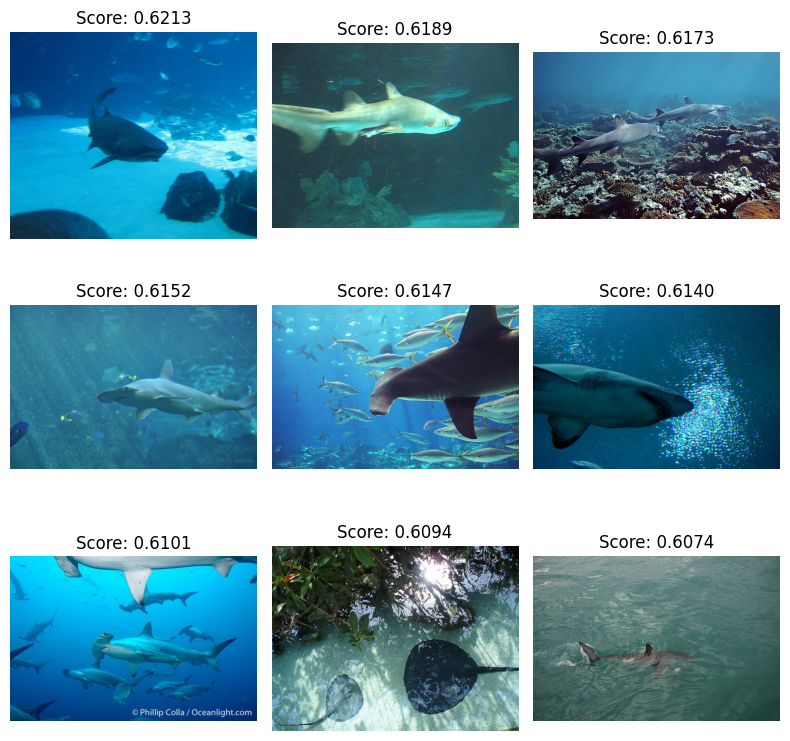

In [17]:
display_images(image_search("sharks in the water"))

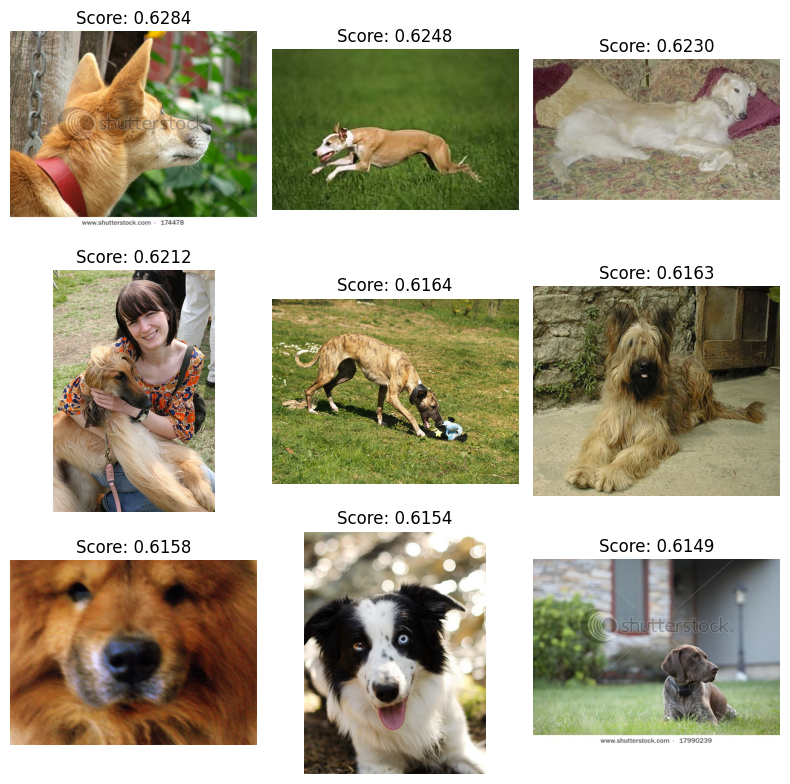

In [18]:
display_images(image_search("Dog with yellow colour"))

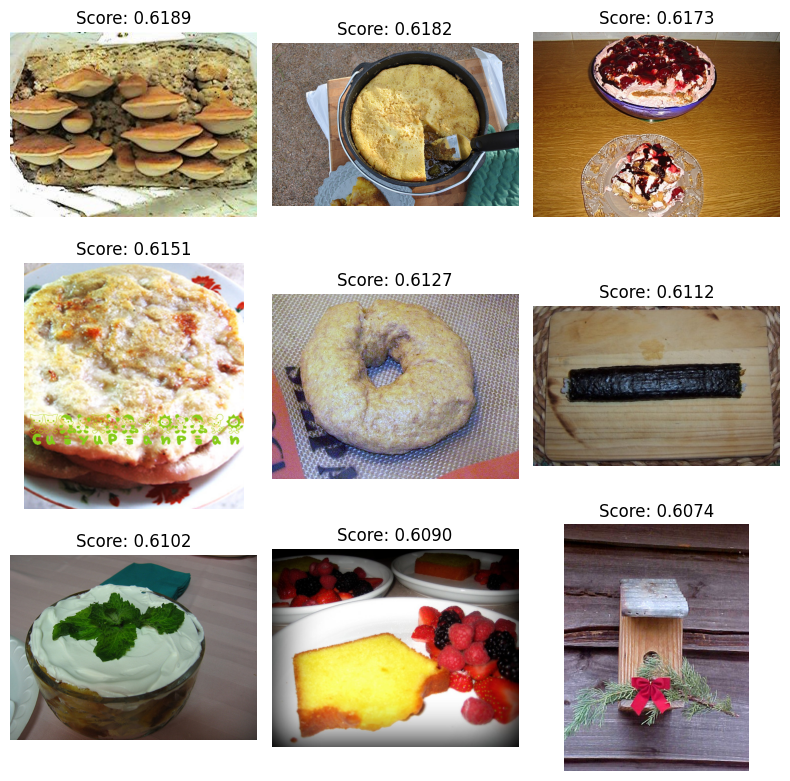

In [19]:
display_images(image_search("Pine cake"))

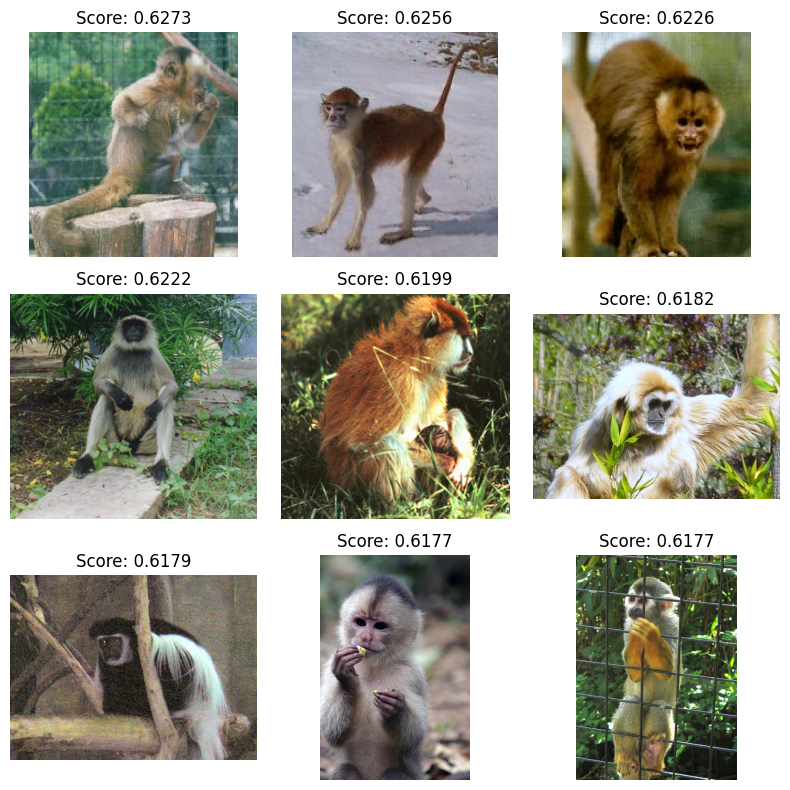

In [20]:
display_images(image_search("monkey"))